In [1]:
import math

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import HTML, display,SVG
import pydot
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    AddDefaultVisualization,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    namedview,
)
from pydrake.examples import (
    AcrobotGeometry,
    AcrobotInput,
    AcrobotPlant,
    AcrobotState,
    QuadrotorGeometry,
    QuadrotorPlant,
    StabilizingLQRController,
)
from pydrake.solvers import MathematicalProgram, Solve

from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer
from underactuated.scenarios import AddFloatingRpyJoint

if running_as_notebook:
    mpld3.enable_notebook()

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [3]:
time_step = 1.0/60.0
test_mode = False

In [4]:
# Clean up the Meshcat instance.
meshcat.Delete()
meshcat.DeleteAddedControls()

# Setup builder and scene.
builder = DiagramBuilder()
body = builder.AddSystem(MultibodyPlant(0.0))
parser = Parser(body)

# Load models
(model_instance,) = parser.AddModelsFromUrl(
    "package://drake/examples/quadrotor/quadrotor.urdf"
)
AddFloatingRpyJoint(
    body,
    body.GetFrameByName("base_link"),
    model_instance,
    use_ball_rpy=False,
)
body.Finalize()

# connect propellers to the body
body_index = body.GetBodyByName("base_link").index()
L = 0.15  # Length of the arms (m).
kF = 1.0  # Force input constant.
kM = 0.0245  # Moment input constant.
prop_info = [
    PropellerInfo(body_index, RigidTransform([L, 0, 0]), kF, kM),
    PropellerInfo(body_index, RigidTransform([0, L, 0]), kF, -kM),
    PropellerInfo(body_index, RigidTransform([-L, 0, 0]), kF, kM),
    PropellerInfo(body_index, RigidTransform([0, -L, 0]), kF, -kM),
]
propellers = builder.AddSystem(Propeller(prop_info))
builder.Connect(
    propellers.get_output_port(),
    body.get_applied_spatial_force_input_port(),
)
builder.Connect(
    body.get_body_poses_output_port(),
    propellers.get_body_poses_input_port(),
)
builder.ExportInput(propellers.get_command_input_port(), "u")

quadrotor = builder.Build()

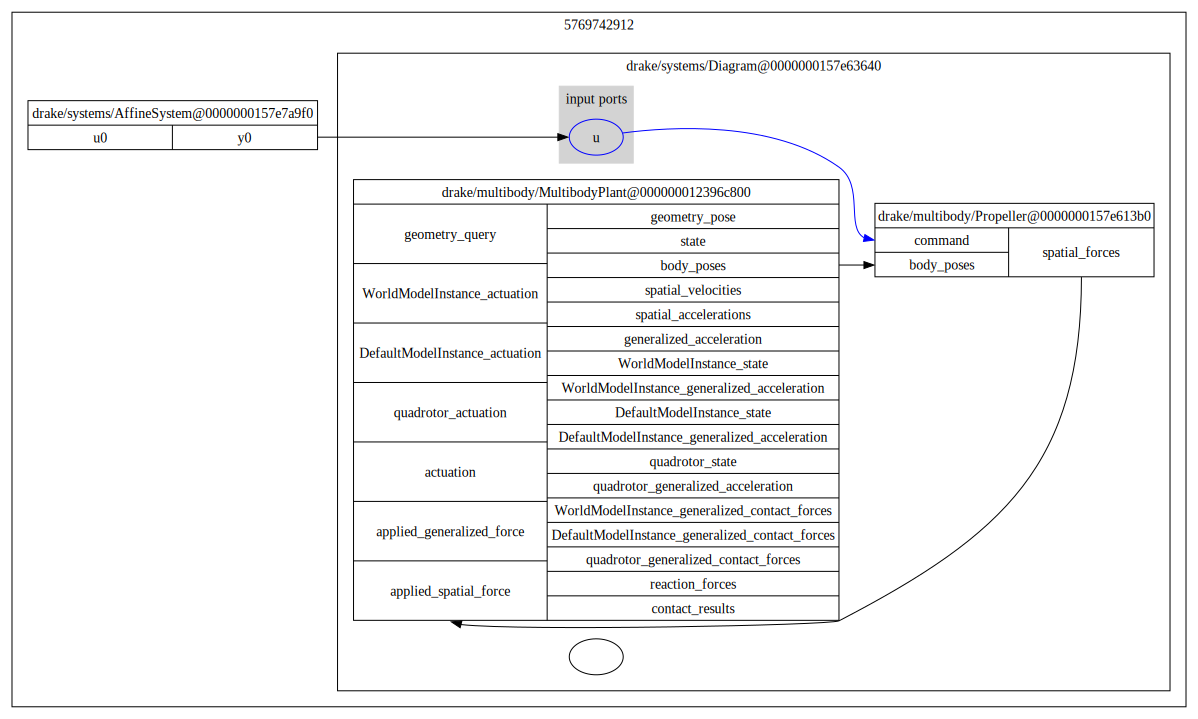

RuntimeError: InputPort::Eval(): required InputPort[0] (u0) of System ::_::drake/systems/AffineSystem@0000000157e7a9f0 (AffineSystem<double>) is not connected

In [5]:
# initial conditions
state_view = namedview("state", body.GetStateNames(False))
context = quadrotor.CreateDefaultContext()
nominal_state = state_view.Zero()
nominal_state.z_x = 1.0
context.SetContinuousState(nominal_state[:])

# get parameters
mass = body.CalcTotalMass(body.GetMyContextFromRoot(context))
gravity = body.gravity_field().gravity_vector()[2]
nominal_input = [-mass * gravity / 4] * 4

# setup controller
quadrotor.get_input_port().FixValue(context, nominal_input)
Q = np.diag(np.concatenate(([10] * 6, [1] * 6)))
R = np.eye(4)
controller = LinearQuadraticRegulator(quadrotor, context, Q, R)

# setup diagram
global_builder = DiagramBuilder()
global_builder.AddSystem(quadrotor)
global_builder.AddSystem(controller)
global_builder.Connect(controller.get_output_port(), quadrotor.get_input_port())

# setup visualizer
# Build the diagram
quadrotor_control = global_builder.Build()
# Visualize the diagram.
display(SVG(pydot.graph_from_dot_data(
    quadrotor_control.GetGraphvizString(max_depth=2))[0].create_svg()))

# run simulation
simulator = Simulator(quadrotor_control)
simulator.Initialize()
simulator.set_target_realtime_rate(1.)
meshcat.StartRecording()
finish_time = 0.1 if test_mode else 2.0
simulator.AdvanceTo(finish_time)
meshcat.PublishRecording()